In [1]:
!pip install albumentations

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings
import json
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm
import albumentations

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 56
SEED = 1488
IMAGE_SIZE = 380
NUM_CLASSES = 6
TRAIN_IMG_PATH = "/app/_data/380_npy/"
TEST_IMG_PATH = "/app/_data/test_images/"
feature_columns = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [4]:
wrong = [
    "ead085dfac287263.jpg",
    "95276ccd226ad933.jpg",
    "da8770e819d2696d.jpg",
    "cd3a1d64e6806eb5.jpg",
    "ccec54723ff91860.jpg",
]
df_labels = pd.read_csv('../_data/df_csv/labels_21_20.csv', index_col=[0])
df_labels = df_labels[['image', 'labels']]
df_labels = df_labels.query('image not in @wrong')
complex_labeled = pd.read_csv('/app/_data/df_csv/complex_labels.csv')
duplicates_labeled = pd.read_csv('/app/_data/df_csv/duplicates_labeled.csv')
duplicates_labeled = duplicates_labeled.dropna(axis=0).reset_index(drop=True)
test_20_labeled = pd.read_csv('../_data/df_csv/test20_labeled.csv', index_col=[0])

In [5]:
df_labels = pd.concat([df_labels,duplicates_labeled, test_20_labeled[['image', 'labels']], complex_labeled], axis=0, ignore_index = True)
df_labels = df_labels.join(df_labels['labels'].str.get_dummies(' '))
df_labels['image'] = df_labels['image'].str.replace('.jpg', '.npy')
df_labels = df_labels.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [6]:
df_labels

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,Test_22.npy,scab rust,0,0,0,0,1,1
1,b5d7d2cdcf0d0c04.npy,scab frog_eye_leaf_spot,0,1,0,0,0,1
2,a462caa19ecd9af8.npy,complex,1,0,0,0,0,0
3,f58390dfa8dda484.npy,complex,1,0,0,0,0,0
4,f43c874bca6786a4.npy,scab,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
22846,a5c9d1d96a336463.npy,rust,0,0,0,0,1,0
22847,b83608aad323ad5f.npy,scab,0,0,0,0,0,1
22848,f69d259c7070c1d3.npy,powdery_mildew,0,0,0,1,0,0
22849,a4a42f96938f4b5c.npy,scab frog_eye_leaf_spot complex,1,1,0,0,0,1


In [7]:
# for 380*380
transform = albumentations.Compose(
    [
        albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
        albumentations.OneOf(
            [
                albumentations.MotionBlur((3, 3)),
                albumentations.MedianBlur(blur_limit=3),
                albumentations.GaussianBlur(
                    blur_limit=(3, 3), sigma_limit=0),
                albumentations.Blur(blur_limit=(3, 3)),
            ],
            p=0.2,
        ),
        albumentations.OneOf(
            [
                albumentations.GaussNoise(var_limit=[10, 50], mean=1),
                albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.01, 0.05)),
                albumentations.ImageCompression(
                    quality_lower=70, quality_upper=100, compression_type=1
                ),
                albumentations.MultiplicativeNoise(
                    multiplier=(0.95, 1.05), per_channel=True, elementwise=True
                ),
                albumentations.Downscale(
                    scale_min=0.6, scale_max=0.99, interpolation=4
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=(-7, 7),
                    sat_shift_limit=(-10, 10),
                    val_shift_limit=(-10, 10),
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.15,
                    contrast_limit=0.2,
                    brightness_by_max=True,
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.OpticalDistortion(
                    distort_limit=0.05,
                    shift_limit=0.05,
                    border_mode=2,
                ),
                albumentations.ElasticTransform(
                    alpha=2.0,
                    sigma=50.0,
                    alpha_affine=10.0,
                    interpolation=0,
                    border_mode=2,
                ),
                albumentations.GridDistortion(
                    num_steps=5, distort_limit=0.3, interpolation=0, border_mode=2
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Rotate(
                    limit=(-180, 180), interpolation=0, border_mode=2
                ),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=180,
                    interpolation=0,
                    border_mode=2,
                ),
            ],
            p=0.5,
        ),
    ]
)

In [8]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        images_src_dir,
        batch_size,
        target_image_size,
        shuffle=False,
        augment = True,
        crop = False,
        resize=False,
        normalize=False
    ):
        self.shuffle = shuffle
        self.batch_size = BATCH_SIZE
        self.df = df
        self.images_dir = images_src_dir
        self.target_image_size = (IMAGE_SIZE, IMAGE_SIZE)
        self.augment = augment
        self.crop = crop
        self.resize = resize
        self.normalize = normalize
        # create label index map
        self.labels = self._read_labels()
        self.n_samples = self.df.shape[0]
        self.n_batches = self.n_samples // self.batch_size
        # shuffle data, also repeated after each epoch if needed
        if self.shuffle:
            np.random.shuffle(self.labels)

    def _read_labels(self):
        """
        Returns list images mapping to 1-hot label
        """


        # label indexes 
        label_ixs = self.df[feature_columns].values
        image_ixs = self.df['image'].values
        labels = []

        for i in range(len(image_ixs)):
            labels.append([image_ixs[i], label_ixs[i]])
        return labels
    
    def __len__(self):
        """
        Length in batches
        """
        return self.n_batches

    def __getitem__(self, b_ix):
        """
        Produce batch, by batch index
        """

        assert b_ix < self.n_batches

        b_X = np.zeros(
            (self.batch_size, self.target_image_size[0], self.target_image_size[1], 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.df[feature_columns].shape[1]),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i], b_Y[i] = self.get_one(
                i + self.batch_size * b_ix,
            )

        return (b_X, b_Y)

    def get_one(
        self, one_ix
    ):
        """
        Get single item by absolute index
        """
        id = self.labels[one_ix][0]
        src_file = self.images_dir+id

        # read file
        x = np.load(src_file)
        if self.crop:
            coord = self.df[self.df["image"] == id][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
            orig_hight = x.shape[0]
            orig_width = x.shape[1]
            x_min = coord[0]
            y_min = coord[1]
            x_max = coord[2]
            y_max = coord[3]
            x = x[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]

        y = self.labels[one_ix][1]

        # augment
        if self.augment:
            x = self._augment_image(x)

        # normalize (sample-wise)
        if self.normalize:
            x = x.astype(np.float32)
            x = x - np.mean(x, axis=(0, 1))
            x = x / np.std(x, axis=(0, 1))
        return x.astype(np.uint8), y

    def _augment_image(self, x):
        """
        Randomply augment image
        """

        x = transform(image=x)['image']
        return x

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.labels)

In [9]:
gen = Generator(
    df=df_labels.head(1).sample(100, replace=True),
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False
)

In [10]:
gen.labels[9]

['Test_22.npy', array([0, 0, 0, 0, 1, 1])]

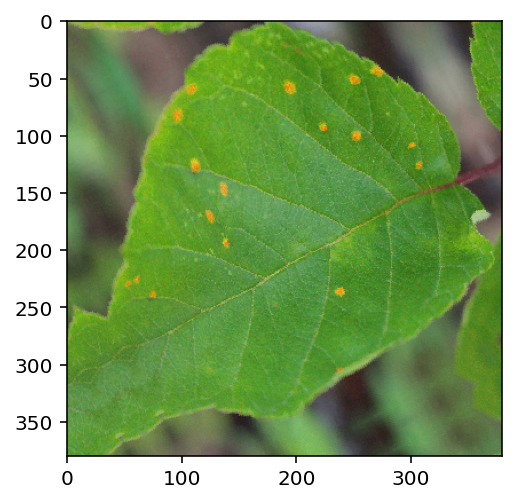

In [11]:
# img = Image.open(gen_train.get_one(1)[0])
plt.imshow(gen.get_one(1)[0])

In [12]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [13]:
def get_model():
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
    base_model.load_weights(
        "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
        by_name=True,
        skip_mismatch=True,
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
        ],
    )
    return model

In [14]:
skf = StratifiedKFold(n_splits=6, random_state=SEED, shuffle=True)

for i, (train_index, valid_index) in enumerate(
    skf.split(df_labels["image"], df_labels["labels"])
):
    train, valid = df_labels.loc[train_index], df_labels.loc[valid_index]
    model_name = "Eff4_all_in_one_" + str(i + 1) + ".h5"
    log_dir = "logs_Eff4_all_in_one__" + str(i + 1) + "/"
    print('\nIter # ', str(i+1), 'starting\n')
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_f1_score",
            patience=22,
            restore_best_weights=True,
            verbose=1,
            mode="max",
        ),
        keras.callbacks.ModelCheckpoint(
            "/app/_data/models/final/Eff7HandComplex/" + model_name,
            monitor="val_f1_score",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
            save_freq=train.shape[0] // (BATCH_SIZE*2),
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_f1_score",
            factor=0.9,
            patience=10,
            verbose=1,
            mode="max",
            min_delta=1e-4,
            min_lr=0.00000001,
        ),
        keras.callbacks.TensorBoard(
            log_dir="/app/.tensorboard/" + log_dir, histogram_freq=0
        ),
        keras.callbacks.experimental.BackupAndRestore(
            "/app/_data/models/final/Eff7HandComplex/backup/"
        ),
        keras.callbacks.TerminateOnNaN()
    ]

    gen_train = Generator(
        df=train,
        images_src_dir=TRAIN_IMG_PATH,
        target_image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=True,
        crop=False,
        resize=False,
    )
    gen_valid = Generator(
        df=valid,
        images_src_dir=TRAIN_IMG_PATH,
        target_image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        augment=False,
        crop=False,
        resize=False,
    )
    model = get_model()
    history = model.fit(
        gen_train,
        validation_data=gen_valid,
        epochs=100,
        steps_per_epoch=train.shape[0] // BATCH_SIZE,
        validation_steps=valid.shape[0] // BATCH_SIZE,
        verbose=1,
        workers=5,
        callbacks=callbacks,
    )
    tf.keras.backend.clear_session()


Iter #  1 starting

Epoch 1/100
  1/340 [..............................] - ETA: 0s - loss: 0.7021 - acc: 0.1786 - recall: 0.6462 - precision: 0.2211 - f1_score: 0.1138WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
340/340 [==============================] - 203s 598ms/step - loss: 0.1704 - acc: 0.8161 - recall: 0.7954 - precision: 0.8357 - f1_score: 0.7921 - val_loss: 0.1632 - val_acc: 0.8469 - val_recall: 0.8231 - val_precision: 0.8502 - val_f1_score: 0.8062
Epoch 2/100
340/340 [==============================] - 194s 572ms/step - loss: 0.1281 - acc: 0.8650 - recall: 0.8595 - precision: 0.8733 - f1_score: 0.8354 - val_loss: 0.1152 - val_acc: 0.8629 - val_recall: 0.8521 - val_precision: 0.8920 - val_f1_score: 0.8389
Epoch 3/100
340/340 [=======================

In [15]:
import kaggle

In [17]:
! kaggle datasets init -p /app/_data/models/final/Eff5HandComplex2/

Data package template written to: /app/_data/models/final/Eff5HandComplex2/dataset-metadata.json


In [18]:
! kaggle datasets create -p /app/_data/models/final/Eff5HandComplex2/

Starting upload for file Eff5HandComplex2_5.h5
100%|█████████████████████████████████████████| 327M/327M [08:14<00:00, 694kB/s]
Upload successful: Eff5HandComplex2_5.h5 (327MB)
Starting upload for file Eff5HandComplex2_4.h5
100%|█████████████████████████████████████████| 327M/327M [08:14<00:00, 693kB/s]
Upload successful: Eff5HandComplex2_4.h5 (327MB)
Starting upload for file Eff5HandComplex2_1.h5
100%|█████████████████████████████████████████| 327M/327M [08:13<00:00, 695kB/s]
Upload successful: Eff5HandComplex2_1.h5 (327MB)
Starting upload for file Eff5HandComplex2_2.h5
100%|█████████████████████████████████████████| 327M/327M [08:19<00:00, 687kB/s]
Upload successful: Eff5HandComplex2_2.h5 (327MB)
Skipping folder: backup; use '--dir-mode' to upload folders
Starting upload for file Eff5HandComplex2_3.h5
100%|█████████████████████████████████████████| 327M/327M [08:15<00:00, 692kB/s]
Upload successful: Eff5HandComplex2_3.h5 (327MB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' t